### Udacity Data Science Nanodegree
### Project 1: Writing a Data Scientist Blog Post
---

# Part II - London Airbnb Data - EDA
## by Juanita Smith


<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

### Context:
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in London, United Kingdom.


### Dictionary:

In Part I, Airbnb London listing data was cleaned, and only a subset of the available features was selected to support analysis of below questions.

**Recap of the origin of data:**

Airbnb activity is included for **London** and is a snapshot of booking availability on 8 June 2023

Data was downloaded from Airbnb [here](http://insideairbnb.com/get-the-data/). Scroll down to London section. 

To support this analysis, only listings and calendar data was needed.

Metadata are available [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

## Are you like me going the Taylor Swift concert in London next June and looking for the best place to stay ?

This project will focus on answering questions below, whilst this notebook focus on **question 4 in blue**

1) Are some hosts running a business, and if so, what is the impact on price ?
> - Can we identify businesses by the duration of rentals ? Are businesses focusing on short or long term term rentals? What impact have rental duration have on price ?
> - Are some hosts running a business with multiple listings ? If so, how does this affect the price ?


2) Host Analysis: How does **host excellence** influence price ?
> - Super hosts seems to describe their properties better, how does this effect price and availability ?


3) What effect does **star ratings** have on property price ?
> - Would a 5-star vs 3-star listing in the same location cost more ?


<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">4) Predict average daily listing price</span>

> - Knowing the impact of host excellence and star ratings above, could we make an accurate average daily price prediction ?

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import os
import missingno as msno
from datetime import datetime

from patsy import dmatrices
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
from project1_blog.src.utils import reduce_mem_usage, create_folder, entity_recognision, fit_imputer
import project1_blog.src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# # use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# stop scientific notation on graphs
# pd.options.display.float_format = '{:.0f}'.format

In [2]:
# set default plot formatting and colors
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_SUB1, BASE_COLOR_SUB2, SYMBOLS = vs.set_plot_defaults()

In [3]:
# default file paths
# FILE_NAME_RAW = '../data/clean/listing_clean.pkl'
# FILE_NAME_CLEAN = '../data/clean/listing_clean.pkl'
FILE_NAME_ENHANCED = '../data/clean/listing_enhanced.pkl'

In [4]:
random_state = 88

<a id='getdata'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Gather Data</span>

In [5]:
# load the enhanced listing file 
listing = pd.read_pickle(FILE_NAME_ENHANCED)
listing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68923 entries, 0 to 69184
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_id                                    68923 non-null  int64  
 1   listing_url                                   68923 non-null  object 
 2   name                                          68923 non-null  object 
 3   host_id                                       68923 non-null  int64  
 4   host_name                                     68923 non-null  object 
 5   host_response_time                            51806 non-null  object 
 6   host_response_rate                            68923 non-null  int16  
 7   host_acceptance_rate                          68923 non-null  int16  
 8   host_is_superhost                             68923 non-null  bool   
 9   host_neighbourhood                            68923 non-null  obje

<a id='featureeng'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Feature engineering</span>

Analyse last outliers and remove them 

In [48]:
listing_clean = listing.copy()

In [49]:
listing_clean.describe([0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

,listing_id,host_id,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years_active,price_mean,minimum_night_ranges
count,6.892300e+04,6.892300e+04,68923.000000,68923.000000,68923.000000,68923.000000,68923.000000,68842.000000,68867.000000,67902.000000,68923.000000,68923.000000,68923.000000,68923.000000,68923.000000,68923.000000,68923.000000,68923.000000,68923.000000,68923.000000,48640.000000,47724.000000,47733.000000,47721.000000,47726.000000,47720.000000,47719.000000,68923.000000,68923.000000,68923.000000,68923.000000,48640.000000,68923.000000,68923.000000,68923.000000
mean,3.504796e+17,1.631639e+08,70.455523,67.677190,51.509690,-0.129571,3.168014,1.338630,1.475975,1.816515,189.713129,4.350202,647.907709,7.478549,18.940122,33.066770,139.935261,18.829462,6.997925,0.736793,4.533813,4.677881,4.597058,4.752845,4.767402,4.709157,4.553347,19.274059,14.502488,4.553574,0.058529,1.170258,6.251208,202.492608,8.695486
std,3.885426e+17,1.676898e+08,43.101723,40.110732,0.048800,0.101330,1.985088,0.676587,0.962448,1.259260,289.025772,9.065348,478.296482,9.613591,20.294365,31.683168,134.490090,44.599790,13.843859,1.502540,0.831564,0.534287,0.581338,0.486279,0.493074,0.441736,0.564701,62.684541,45.014582,26.132366,0.768000,1.416673,3.230126,240.753573,8.488857
min,1.391300e+04,2.594000e+03,0.000000,0.000000,51.295937,-0.497800,1.000000,0.000000,0.000000,1.000000,-11936.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000,7.000000,7.000000
25%,2.517468e+07,2.342688e+07,0.000000,35.000000,51.484790,-0.190558,2.000000,1.000000,1.000000,1.000000,69.000000,1.000000,100.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,4.500000,4.600000,4.500000,4.720000,4.750000,4.620000,4.430000,1.000000,0.000000,0.000000,0.000000,0.270000,4.000000,70.000000,7.000000
50%,5.180034e+07,8.935519e+07,100.000000,91.000000,51.513730,-0.129850,2.000000,1.000000,1.000000,1.000000,120.000000,2.000000,365.000000,3.000000,11.000000,26.000000,92.000000,4.000000,2.000000,0.000000,4.790000,4.860000,4.780000,4.920000,4.940000,4.830000,4.700000,2.000000,1.000000,0.000000,0.000000,0.720000,7.000000,129.000000,7.000000
75%,7.664947e+17,2.792996e+08,100.000000,100.000000,51.538970,-0.069360,4.000000,1.500000,2.000000,2.000000,209.000000,4.000000,1125.000000,12.000000,34.000000,61.000000,279.000000,17.000000,8.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.900000,7.000000,4.000000,1.000000,0.000000,1.530000,9.000000,232.000000,7.000000
90%,8.649478e+17,4.597220e+08,100.000000,100.000000,51.566208,-0.011270,6.000000,2.000000,3.000000,3.000000,360.000000,7.000000,1125.000000,26.000000,54.000000,83.000000,347.000000,50.000000,20.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,40.000000,31.000000,4.000000,0.000000,2.890000,10.000000,409.000000,7.000000
99%,9.049446e+17,5.111721e+08,100.000000,100.000000,51.624190,0.141005,10.000000,3.500000,5.000000,6.000000,1500.000000,45.000000,1125.000000,30.000000,60.000000,90.000000,365.000000,219.000000,65.000000,7.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,291.000000,280.000000,103.000000,1.000000,6.466100,12.000000,1507.780000,49.000000
99.9%,9.085061e+17,5.178395e+08,100.000000,100.000000,51.660925,0.217254,16.000000,5.500000,7.0

In [50]:
# remove records with listings hosting too many people
listing_clean = listing_clean[listing_clean['accommodates'] <= 10]
listing_clean = listing_clean[listing_clean['bedrooms'] <= 6]
listing_clean = listing_clean[listing_clean['bathrooms'] <= 5]
listing_clean.describe([0.25, 0.5, 0.75, 0.9, 0.99, 0.999])

,listing_id,host_id,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_minimum_nights,minimum_maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_years_active,price_mean,minimum_night_ranges
count,6.828200e+04,6.828200e+04,68282.000000,68282.00000,68282.000000,68282.000000,68282.000000,68282.000000,68282.000000,67297.000000,68282.000000,68282.000000,68282.000000,68282.000000,68282.000000,68282.000000,68282.000000,68282.000000,68282.000000,68282.000000,48215.000000,47305.000000,47314.000000,47302.000000,47307.000000,47301.000000,47300.000000,68282.000000,68282.000000,68282.000000,68282.000000,48215.000000,68282.000000,68282.000000,68282.000000
mean,3.509533e+17,1.632880e+08,70.391465,67.64547,51.509638,-0.129629,3.105196,1.321959,1.448815,1.778697,187.302217,4.358586,647.284585,7.451437,18.895375,32.998682,139.516227,18.812557,7.003163,0.738526,4.533739,4.678253,4.597432,4.752611,4.767411,4.709532,4.553588,19.279166,14.498067,4.565991,0.058317,1.171622,6.247752,200.029334,8.702689
std,3.886130e+17,1.677429e+08,43.142651,40.12800,0.048729,0.101109,1.821389,0.577474,0.871831,1.142469,286.472708,9.082424,478.257094,9.596100,20.274430,31.666308,134.357320,44.558438,13.855145,1.505211,0.832428,0.534674,0.581824,0.487094,0.493592,0.442207,0.565242,62.856832,45.114857,26.221530,0.768496,1.418862,3.229363,237.173868,8.506387
min,1.391300e+04,2.594000e+03,0.000000,0.00000,51.295937,-0.497800,1.000000,0.000000,0.000000,1.000000,-11936.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000,7.000000,7.000000
25%,2.518168e+07,2.357929e+07,0.000000,35.00000,51.484804,-0.190500,2.000000,1.000000,1.000000,1.000000,68.000000,1.000000,99.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,4.500000,4.600000,4.500000,4.720000,4.750000,4.620000,4.430000,1.000000,0.000000,0.000000,0.000000,0.270000,4.000000,70.000000,7.000000
50%,5.183734e+07,8.935519e+07,100.000000,91.00000,51.513700,-0.129864,2.000000,1.000000,1.000000,1.000000,120.000000,2.000000,365.000000,3.000000,11.000000,26.000000,91.000000,4.000000,2.000000,0.000000,4.790000,4.860000,4.780000,4.920000,4.950000,4.830000,4.700000,2.000000,1.000000,0.000000,0.000000,0.720000,7.000000,128.000000,7.000000
75%,7.665933e+17,2.801358e+08,100.000000,100.00000,51.538850,-0.069439,4.000000,1.500000,2.000000,2.000000,206.000000,4.000000,1125.000000,12.000000,34.000000,61.000000,278.000000,17.000000,8.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.900000,7.000000,4.000000,1.000000,0.000000,1.530000,9.000000,230.000000,7.000000
90%,8.650406e+17,4.600733e+08,100.000000,100.00000,51.565910,-0.011663,6.000000,2.000000,3.000000,3.000000,351.000000,7.000000,1125.000000,26.000000,54.000000,83.000000,347.000000,50.000000,20.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,40.000000,31.000000,4.000000,0.000000,2.890000,10.000000,401.000000,7.000000
99%,9.049523e+17,5.113322e+08,100.000000,100.00000,51.624260,0.140302,9.000000,3.500000,4.000000,6.000000,1500.000000,45.000000,1125.000000,30.000000,60.000000,90.000000,365.000000,219.000000,65.000000,7.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,291.000000,280.000000,103.000000,1.000000,6.470000,12.000000,1500.000000,49.000000
99.9%,9.085079e+17,5.178395e+08,100.000000,100.00000,51.660843,0.215383,10.000000,5.000000,5.000000,8.0000

<a id='univariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Univariate Analysis</span>

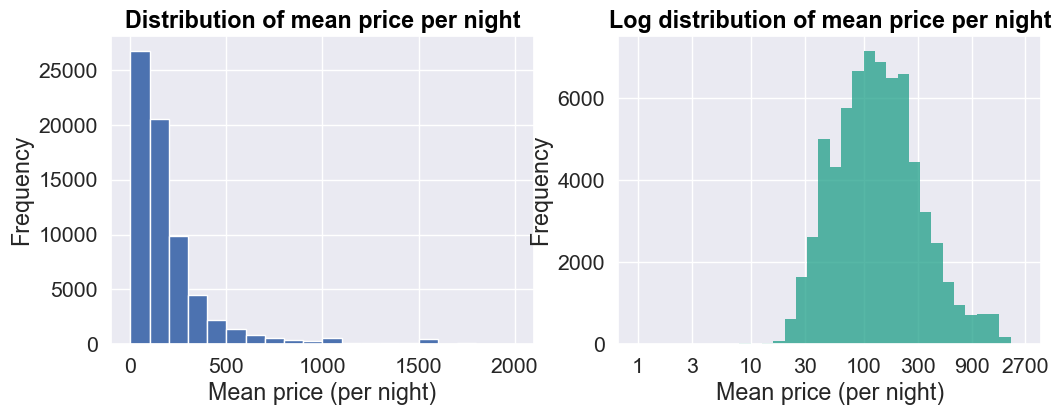

In [51]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
xbinsize = 100
xbins = np.arange(0, listing_clean['price_mean'].max()+xbinsize, xbinsize)
plt.hist(data=listing, x='price_mean', bins=xbins)
plt.title('Distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
log_binsize = 0.1
xbins = 10 ** np.arange(0, np.log10(listing_clean['price_mean'].max())+log_binsize, log_binsize)
sns.histplot(data=listing, x='price_mean', bins=xbins, color=BASE_COLOR_SUB2, kde=False)
ticks = [1, 3, 10, 30, 100, 300, 900, 2700]
labels = ['{}'.format(tick) for tick in ticks]

plt.xscale('log')
plt.xticks(ticks,labels)

plt.title('Log distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.show()

In [52]:
# Log-transform the skewed features
listing_clean['price_mean'] = listing_clean['price_mean'].apply(lambda x: np.log10(x+1))
listing_clean['price_mean'].describe()

count    68282.000000
mean         2.125807
std          0.374076
min          0.903090
25%          1.851258
50%          2.110590
75%          2.363612
max          3.301247
Name: price_mean, dtype: float64

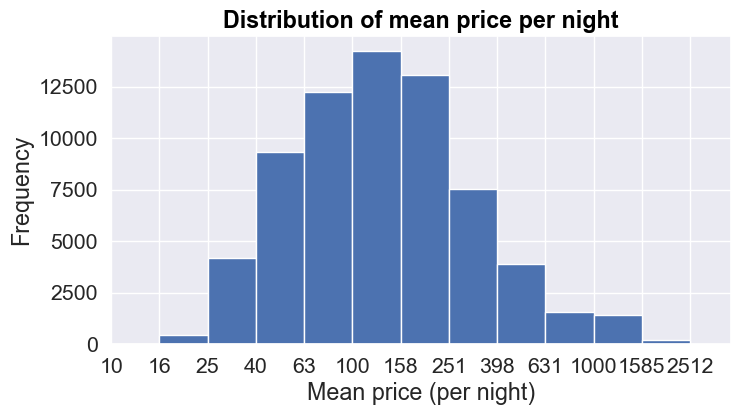

In [53]:
log_binsize = 0.2
xbins = np.arange(0, listing_clean['price_mean'].max()+log_binsize, log_binsize)

plt.hist(data=listing_clean, x='price_mean', bins=xbins)

xticks, xlabels = plt.xticks()
xlabels = ['{:.0f}'.format(10**val) for val in xbins]
plt.xticks(xbins, xlabels)

plt.xlim(1)

plt.title('Distribution of mean price per night')
plt.xlabel('Mean price (per night)')
plt.ylabel('Frequency')

plt.show()

<a id='Bivariate'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Bivariate Analysis</span>

#### Correlation analysis
- Select features correlated with price
- Make sure independent variables does not have too high correlations

In [54]:
cols_to_drop = ['latitude', 'longitude', 
                'minimum_maximum_nights', 
                # 'minimum_minimum_nights',
                'minimum_night_ranges', 
                'host_id', 'host_name', 'listing_id', 'listing_url',
                'host_neighbourhood', 'first_review', 'last_review', 'name',
                'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
                'calculated_host_listings_count_shared_rooms', 
                'instant_bookable',
                'number_of_reviews_l30d', 'reviews_per_month', 'number_of_reviews_ltm', 
                'number_of_reviews',
                'price',
                'review_scores_checkin', 'review_scores_communication', 'review_scores_cleanliness', 
                'review_scores_value', 'review_scores_accuracy', 
                'review_scores_rating', 'review_scores_location',
                'availability_365', 
                'availability_30', 
                'availability_60',
                'availability_90',
                'beds', 
                # 'accommodates', 
                # 'bathrooms',
                # 'bedrooms',
                'host_has_about', 'host_has_neighborhood_overview', 'host_identity_verified',
                'host_acceptance_rate', 'host_response_rate', 'host_has_profile_pic', 'host_response_time',
                # 'is_business',
                # 'room_type', 
                'property_type',
                # 'neighbourhood_cleansed'
                ]

In [55]:
listing_clean = listing_clean.drop(cols_to_drop, axis=1)

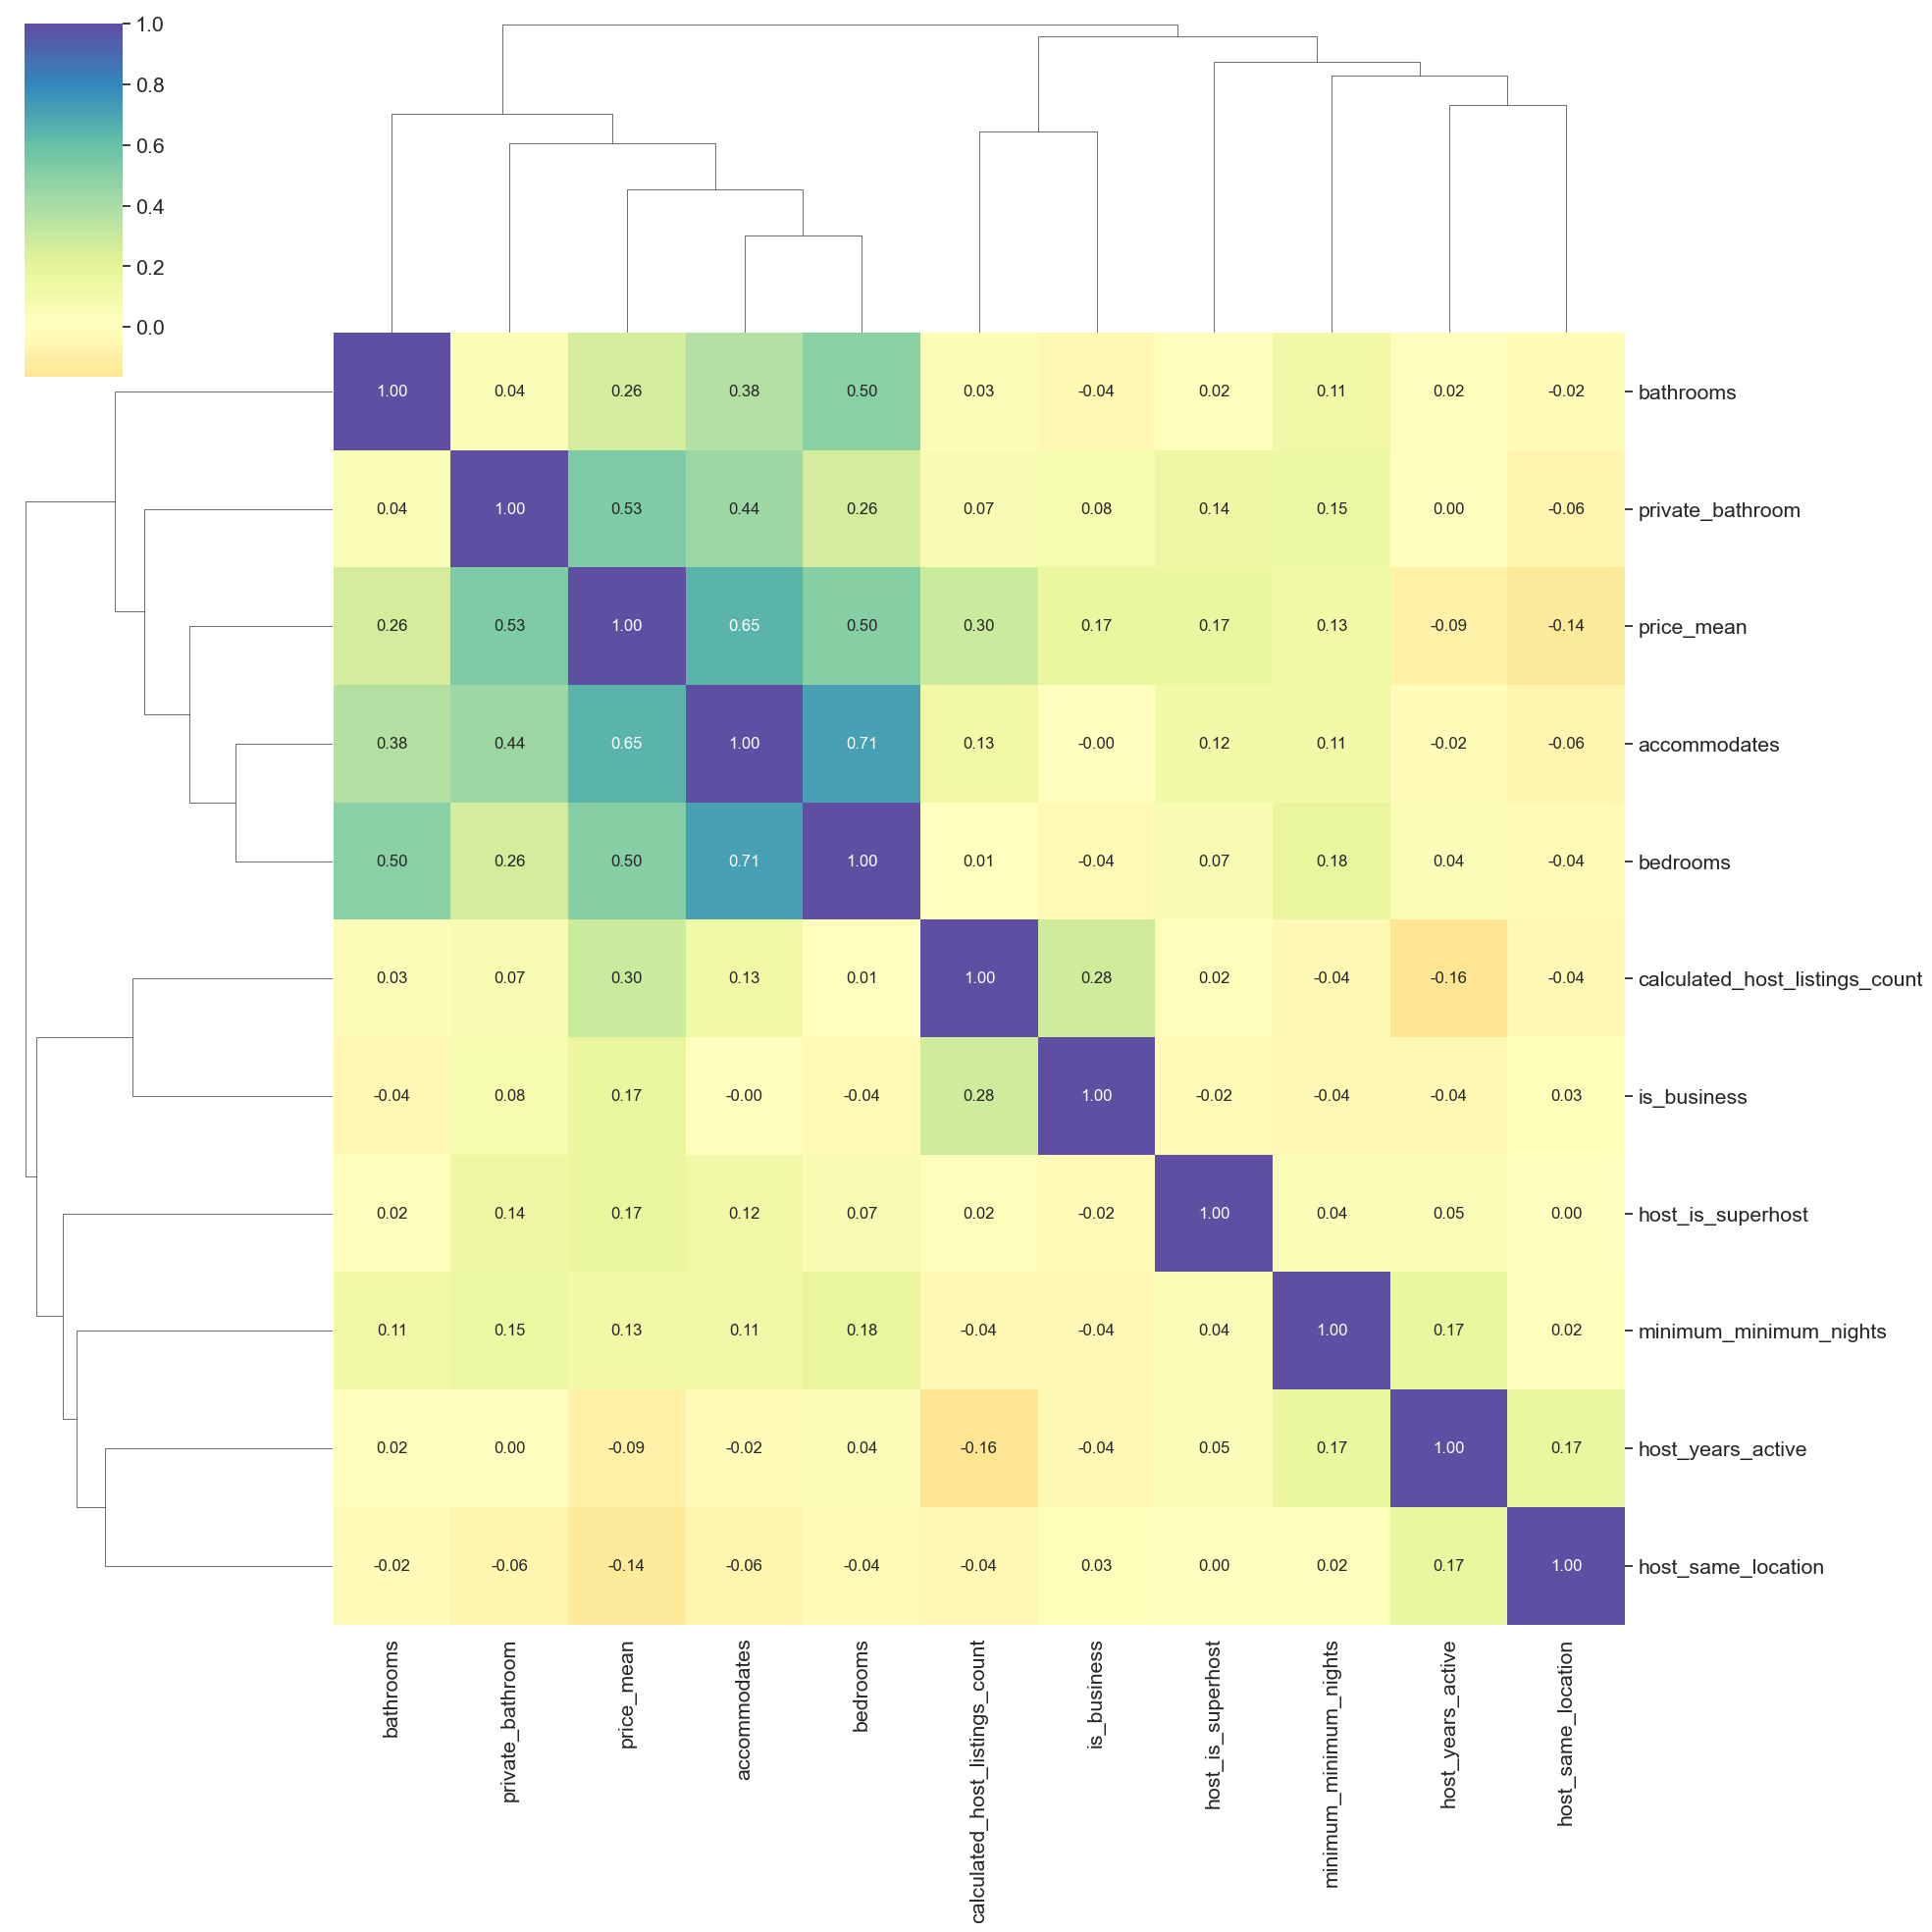

In [56]:
sns.set(font_scale=1.4)
sns.clustermap(listing_clean.corr(method='spearman', numeric_only=True, min_periods=1), cmap="Spectral", center=0, annot=True, fmt='.2f', 
               annot_kws={"fontsize":12}, figsize=(20,20))

plt.xticks(fontsize=14)
plt.show()

In [57]:
listing_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68282 entries, 0 to 69184
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_is_superhost               68282 non-null  bool   
 1   neighbourhood_cleansed          68282 non-null  object 
 2   room_type                       68282 non-null  object 
 3   accommodates                    68282 non-null  int64  
 4   bathrooms                       68282 non-null  float64
 5   bedrooms                        68282 non-null  float64
 6   minimum_minimum_nights          68282 non-null  int64  
 7   calculated_host_listings_count  68282 non-null  int64  
 8   host_years_active               68282 non-null  int64  
 9   price_mean                      68282 non-null  float64
 10  private_bathroom                68282 non-null  bool   
 11  host_same_location              68282 non-null  bool   
 12  is_business                     68282

In [58]:
# # Correlation analysis

# # take a sample of listings to speed of performance for regplot relationship
# sample = np.random.choice(listing_reduced.shape[0], 20000, replace=False)
# listing_sample = listing_reduced.iloc[sample].copy()

# # listing_sample = listing_sample[cols_of_interest].copy()
# listing_sample.dropna(inplace=True)

# sns.set(style='ticks')

# x_vars = ["price_mean"]

# g = sns.PairGrid(data=listing_sample, dropna=True, x_vars=x_vars, height=2, aspect=2,)
# g.map_diag(sns.histplot, color=BASE_HIGHLIGHT, hue=None, palette=None)
# # g.map_offdiag(sns.scatterplot, alpha=0.1)
# g.map_offdiag(sns.regplot, fit_reg=True, y_jitter=0.1, x_jitter=0.1, truncate=True, scatter_kws={'s':10, 'edgecolor':'white', 'alpha':0.05})
    
# plt.suptitle('Correlations between features of interest')
# leg = g.add_legend(title='Is Business ?', fontsize='small', title_fontsize='large', loc='upper center')  
# g._legend.set_bbox_to_anchor((0.5, 0.75))

# g.tight_layout()

# # reset default plot formatting back as PairGrid change the defaults somehow
# BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [59]:
# test = listing.loc[:,['neighbourhood_cleansed', 'price_mean']]
# test['price_mean'] = test.price_mean **10          

# test = test.groupby('neighbourhood_cleansed')['price_mean'].mean().sort_values(ascending=False)
# test.head()

In [60]:
listing_clean.accommodates.value_counts()

accommodates
2     28138
4     13843
1      9058
6      5236
3      5124
5      3557
8      1494
7      1063
10      436
9       333
Name: count, dtype: int64

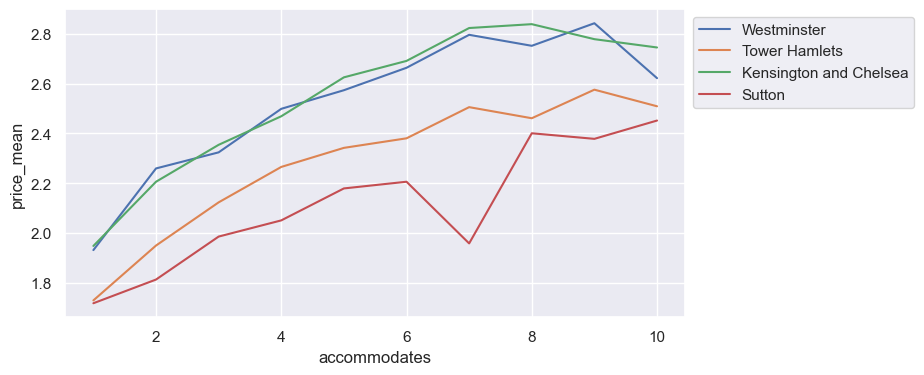

In [61]:
sns.set(font_scale=1)
sns.lineplot(data=listing_clean, x='accommodates', y='price_mean', hue='neighbourhood_cleansed', errorbar=None, 
             hue_order=['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Sutton']);
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

**Observation**:
- slopes do not match, we will need an interaction term

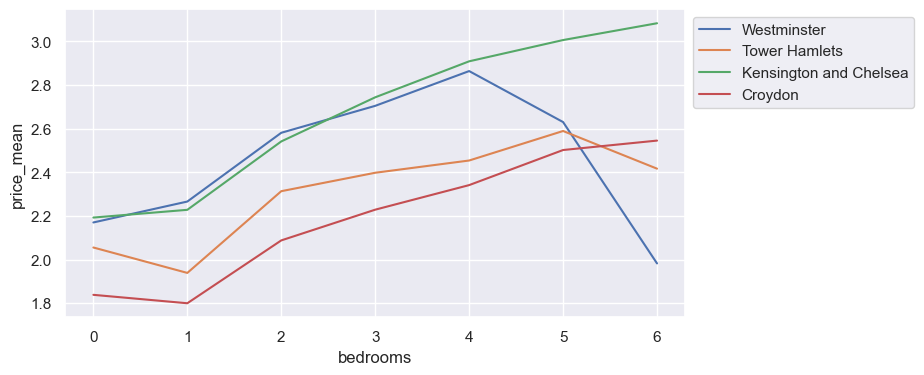

In [62]:
sns.lineplot(data=listing_clean, x='bedrooms', y='price_mean', hue='neighbourhood_cleansed', errorbar=None, 
             hue_order=['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Croydon']);
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

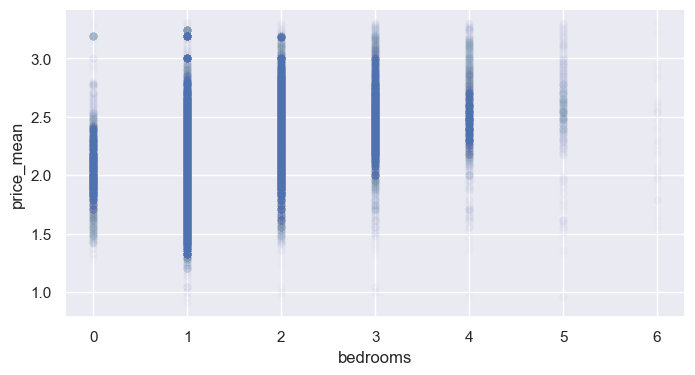

In [63]:
sns.scatterplot(data=listing_clean, x='bedrooms', y='price_mean', alpha=0.01);

### Cleaning

In [64]:
def clean_data(df, y_feature='price_mean', random_state=88):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''

    # Drop rows with missing values in y-feature to be predicted
    df = df.dropna(subset=[y_feature], axis=0)   

    bool_vars = list(df.select_dtypes(include=['bool']).copy().columns)

    # Dummy the categorical variables
    cat_vars = list(df.select_dtypes(include=['object', 'bool']).copy().columns)
    print('dummy vars {}'.format(cat_vars))
    if len(cat_vars) > 0:
        df = pd.get_dummies(data=df, 
                            columns=cat_vars, 
                            dummy_na=False, 
                            prefix_sep='_', 
                            drop_first=True)

    # remove spaces from column names 
    df.columns = df.columns.str.replace(' ', '_', regex=False)
    
    # restrict the values to be predicted to a min / max range
    minimum_before = list(df.iloc[:, :].min(axis=0))
    maximum_before = list(df.iloc[:, :].max(axis=0))

    # impute missing values
    imputer = IterativeImputer(random_state=random_state,
                               imputation_order='descending',
                               n_nearest_features=10,
                               initial_strategy='mean',
                               max_iter=30,
                               min_value=minimum_before,
                               max_value=maximum_before,
                               skip_complete=True,
                               # tol=0.0001, 
                               verbose=0)

    df[:] = imputer.fit_transform(df) 

    # prepare X and y datasets
    y = df[y_feature]  
    X = df.drop(y_feature, axis=1)

    # scale data
    # don't scale data for binary variables and see what happens

    # s.str.startswith(('b', 'B'))

    # string_cols = [col for col in X.columns if col.str.startswith(bool_vars)]
    scaler = StandardScaler()
    # X[string_cols]= scaler.fit_transform(X[string_cols])     
    X[:]= scaler.fit_transform(X[:])     
    
    return X, y, scaler

In [65]:
#Use the function to create X and y
X, y, scaler = clean_data(listing_clean.copy(deep=True), y_feature='price_mean')   

dummy vars ['host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'private_bathroom', 'host_same_location', 'is_business']


In [66]:
print(X.shape)
try:
    X.drop('neighbourhood_cleansed_Westminster', axis=1, inplace=True)    
except:
    pass
print(X.shape)

(68282, 45)
(68282, 44)


In [67]:
X.head()

,accommodates,bathrooms,bedrooms,minimum_minimum_nights,calculated_host_listings_count,host_years_active,host_is_superhost_True,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City_of_London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith_and_Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington_and_Chelsea,neighbourhood_cleansed_Kingston_upon_Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond_upon_Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower_Hamlets,neighbourhood_cleansed_Waltham_Forest,neighbourhood_cleansed_Wandsworth,room_type_Hotel_room,room_type_Private_room,room_type_Shared_room,private_bathroom_True,host_same_location_True,is_business_True
0,-0.057756,0.308313,-0.51480,-0.039482,-0.290808,1.781246,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,4.734588,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,-0.274267,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,1.301046,-0.073309,0.516735,2.425258,-0.228314
1,-1.155827,-0.557534,-0.51480,-0.369792,-0.274899,2.400568,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,4.333638,-0.274267,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,1.301046,-0.073309,-1.935226,2.425258,-0.228314
2,-0.606792,-0.557534,-0.51480,0.290829,-0.290808,2.400568,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,3.646081,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,-0.768612,-0.073309,0.516735,2.425258,-0.228314
3,1.040315,-0.557534,0.63222,-0.259689,-0.290808,1.471585,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,3.817292,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,-0.274267,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,-0.768612,-0.073309,0.516735,-0.412327,-0.228314
4,-0.606792,-0.557534,-0.51480,-0.039482,-0.243081,1.781246,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,-0.274267,-0.088614,4.332316,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,1.301046,-0.073309,-1.935226,-0.412327,-0.228314


### Test for multicollinearity

In [68]:
#gather features
vip_features = " + ".join(X.columns)
vip_features

'accommodates + bathrooms + bedrooms + minimum_minimum_nights + calculated_host_listings_count + host_years_active + host_is_superhost_True + neighbourhood_cleansed_Barnet + neighbourhood_cleansed_Bexley + neighbourhood_cleansed_Brent + neighbourhood_cleansed_Bromley + neighbourhood_cleansed_Camden + neighbourhood_cleansed_City_of_London + neighbourhood_cleansed_Croydon + neighbourhood_cleansed_Ealing + neighbourhood_cleansed_Enfield + neighbourhood_cleansed_Greenwich + neighbourhood_cleansed_Hackney + neighbourhood_cleansed_Hammersmith_and_Fulham + neighbourhood_cleansed_Haringey + neighbourhood_cleansed_Harrow + neighbourhood_cleansed_Havering + neighbourhood_cleansed_Hillingdon + neighbourhood_cleansed_Hounslow + neighbourhood_cleansed_Islington + neighbourhood_cleansed_Kensington_and_Chelsea + neighbourhood_cleansed_Kingston_upon_Thames + neighbourhood_cleansed_Lambeth + neighbourhood_cleansed_Lewisham + neighbourhood_cleansed_Merton + neighbourhood_cleansed_Newham + neighbourhood_

In [69]:
# merge X and y as required by statsmodels
vip_df = X.merge(y, left_index=True, right_index=True)
vip_df.head()

,accommodates,bathrooms,bedrooms,minimum_minimum_nights,calculated_host_listings_count,host_years_active,host_is_superhost_True,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City_of_London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith_and_Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington_and_Chelsea,neighbourhood_cleansed_Kingston_upon_Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond_upon_Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower_Hamlets,neighbourhood_cleansed_Waltham_Forest,neighbourhood_cleansed_Wandsworth,room_type_Hotel_room,room_type_Private_room,room_type_Shared_room,private_bathroom_True,host_same_location_True,is_business_True,price_mean
0,-0.057756,0.308313,-0.51480,-0.039482,-0.290808,1.781246,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,4.734588,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,-0.274267,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,1.301046,-0.073309,0.516735,2.425258,-0.228314,1.851258
1,-1.155827,-0.557534,-0.51480,-0.369792,-0.274899,2.400568,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,4.333638,-0.274267,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,1.301046,-0.073309,-1.935226,2.425258,-0.228314,1.903090
2,-0.606792,-0.557534,-0.51480,0.290829,-0.290808,2.400568,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,3.646081,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,-0.768612,-0.073309,0.516735,2.425258,-0.228314,2.033424
3,1.040315,-0.557534,0.63222,-0.259689,-0.290808,1.471585,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,3.817292,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,-0.274267,-0.088614,-0.230823,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,-0.768612,-0.073309,0.516735,-0.412327,-0.228314,2.298853
4,-0.606792,-0.557534,-0.51480,-0.039482,-0.243081,1.781246,-0.320928,-0.164733,-0.078576,-0.185143,-0.094864,-0.269827,-0.078008,-0.134314,-0.162894,-0.099396,-0.150787,-0.261966,-0.211212,-0.162087,-0.080257,-0.069688,-0.104098,-0.119541,-0.230753,-0.274267,-0.088614,4.332316,-0.168585,-0.130361,-0.164733,-0.100591,-0.120044,-0.242453,-0.067969,-0.290948,-0.137555,-0.225674,-0.053654,1.301046,-0.073309,-1.935226,-0.412327,-0.228314,1.799341


In [70]:
sm_y, sm_X = dmatrices('price_mean ~' + vip_features, vip_df, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(sm_X.values, i) for i in range(sm_X.shape[1])]
vif['features'] = sm_X.columns
vif

,VIF Factor,features
0,1.000000,Intercept
1,3.144449,accommodates
2,1.522674,bathrooms
3,2.935576,bedrooms
4,1.024351,minimum_minimum_nights
5,1.266817,calculated_host_listings_count
6,1.086978,host_years_active
7,1.051882,host_is_superhost_True
8,1.189519,neighbourhood_cleansed_Barnet
9,1.049946,neighbourhood_cleansed_Bexley


### Modelling

In [71]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=88, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:
        print('start of cutoff {}'.format(cutoff))

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])
        
        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression()
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(bbox_to_anchor=(1,1), loc='upper left')
        plt.show()

    print('building final model')
    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

In [72]:
#cutoffs here pertains to the variability especially in dummy variables. 
#If there are too little 1's in for example property type dummy variables, there is not enough variabilty for prediction
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [1]

# r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs, plot=True)

In [73]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [74]:
#fit the model and obtain pred response
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)

In [75]:
residuals = y_test - y_pred

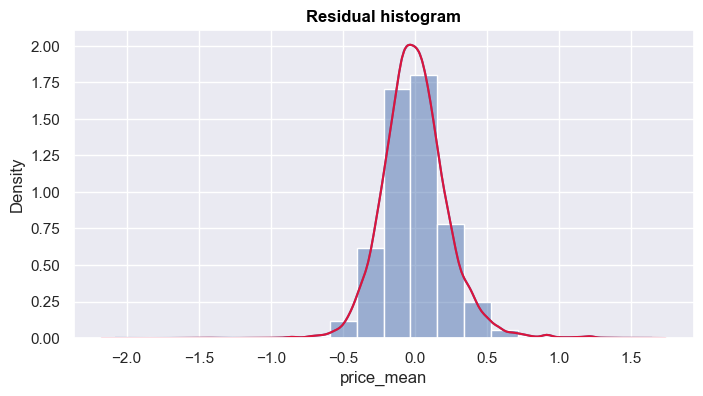

In [76]:
# residuals should be normally distributed, let's test that
ax = sns.histplot(residuals, bins=20, stat='density', kde=True)
sns.kdeplot(residuals, color='crimson', ax=ax)

plt.title('Residual histogram')

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

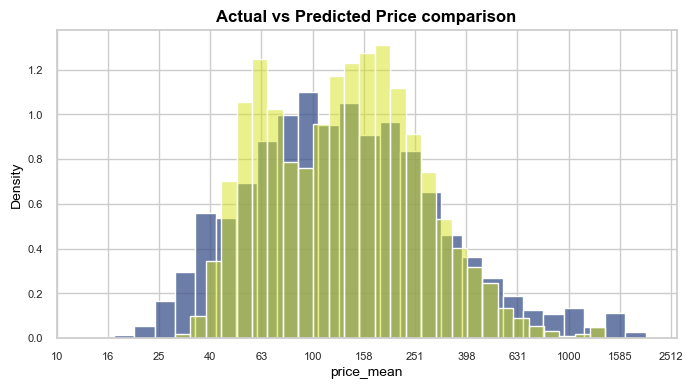

In [77]:
# residuals should be normally distributed, let's test that
ax = sns.histplot(y_test, bins=30, stat='density', kde=False, color=BASE_COLOR, label='actual')

ax2 = sns.histplot(y_pred, bins=30, stat='density', kde=False, color=BASE_COMPLEMENTRY, alpha=0.5, label='predicted')

xticks, xlabels = plt.xticks()
xlabels = ['{:.0f}'.format(10**val) for val in xbins]
plt.xticks(xbins, xlabels)
plt.xlim(1)

plt.title('Actual vs Predicted Price comparison')

plt.show()

# reset default plot formatting back as PairGrid change the defaults somehow
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [78]:
# print(X_train.shape[1]) #Number of columns
# print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
# print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

In [79]:
# Import the metrics from sklearn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print('Mean Squared Error: ', format(mean_squared_error(y_test, y_pred)))
print('Mean Absolute Error: ', format(mean_absolute_error(y_test, y_pred)))
print('R2 Score: ', format(r2_score(y_test, y_pred)))
print('\n\n')

Mean Squared Error:  0.051300184641771725
Mean Absolute Error:  0.1691810602693403
R2 Score:  0.6342000214474484



In [80]:
# training scores
y_train_preds = lm_model.predict(X_train)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_preds))
# The coefficient of determination: 1 is perfect prediction
print("R-squared: %.2f" % r2_score(y_train, y_train_preds))

Mean squared error: 0.05
R-squared: 0.64


In [81]:
# testing scores
y_test_preds = lm_model.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_preds))
# The coefficient of determination: 1 is perfect prediction
print("R-squared: %.2f" % r2_score(y_test, y_test_preds))

# best so far is 0.01, 0.53 when using mean log prices, accommodates, without bedrooms and bathrooms

Mean squared error: 0.05
R-squared: 0.63


In [82]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df

,est_int,coefs,abs_coefs
39,room_type_Private_room,-0.101581,0.101581
4,calculated_host_listings_count,0.093608,0.093608
0,accommodates,0.087565,0.087565
35,neighbourhood_cleansed_Tower_Hamlets,-0.046703,0.046703
28,neighbourhood_cleansed_Lewisham,-0.045063,0.045063
41,private_bathroom_True,0.043442,0.043442
17,neighbourhood_cleansed_Hackney,-0.041795,0.041795
7,neighbourhood_cleansed_Barnet,-0.040759,0.040759
13,neighbourhood_cleansed_Croydon,-0.038596,0.038596
27,neighbourhood_cleansed_Lambeth,-0.037971,0.037971


# statsmodels model statistics

In [83]:
X_ols = X_train.copy()
X_ols['intercept'] = 1
lm = sm.OLS(y_train, X_ols)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_mean   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     1943.
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:26:56   Log-Likelihood:                 3723.6
No. Observations:               47797   AIC:                            -7357.
Df Residuals:                   47752   BIC:                            -6962.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
accommodates                                      0.0876      0.002     48.162      0.000       0.084       0.091
bathrooms                                         0.0362      0.001     28.488      0.000       0.034       0.039
bedrooms                                          0.0378      0.002     21.389      0.000       0.034       0.041
minimum_minimum_nights                           -0.0142      0.001    -13.671      0.000      -0.016      -0.012
calculated_host_listings_count                    0.0936      0.001     81.150      0.000       0.091       0.096
host_years_active                                -0.0269      0.001    -25.195      0.000      -0.029      -0.025
host_is_superhost_True                            0.0193      0.001     18.555      0.000       0.017       0.021
neighbourhood_cleansed_Barnet                    -0.0408      0.001    -36.830      0.000      -0.043      -0.039
neighbourhood_cleansed_Bexley                    -0.0248      0.001    -23.855      0.000      -0.027      -0.023
neighbourhood_cleansed_Brent                     -0.0345      0.001    -30.109      0.000      -0.037      -0.032
neighbourhood_cleansed_Bromley                   -0.0256      0.001    -23.949      0.000      -0.028      -0.023
neighbourhood_cleansed_Camden                    -0.0218      0.001    -17.796      0.000      -0.024      -0.019
neighbourhood_cleansed_City_of_London            -0.0011      0.001     -1.035      0.301      -0.003       0.001
neighbourhood_cleansed_Croydon                   -0.0386      0.001    -34.892      0.000      -0.041      -0.036
neighbourhood_cleansed_Ealing                    -0.0376      0.001    -33.611      0.000      -0.040      -0.035
neighbourhood_cleansed_Enfield                   -0.0238      0.001    -22.078      0.000      -0.026      -0.022
neighbourhood_cleansed_Greenwich                 -0.0341      0.001    -30.602      0.000      -0.036      -0.032
neighbourhood_cleansed_Hackney                   -0.0418      0.001    -33.989      0.000      -0.044      -0.039
neighbourhood_cleansed_Hammersmith_and_Fulham    -0.0233      0.001    -20.130      0.000      -0.026      -0.021
neighbourhood_cleansed_Haringey                  -0.0360      0.001    -32.060      0.000      -0.038      -0.034
neighbourhood_cleansed_Harrow                    -0.0217      0.001    -20.442      0.000      -0.024      -0.020
neighbourhood_cleansed_Havering                  -0.0192      0.001    -18.419      0.000      -0.021      -0.017
neighbourhood_cleansed_Hillingdon                -0.0254      0.001    -24.402      0.000      -0.027      -0.023
neighbourhood_cleansed_Hounslow                  -0.0250      0.001    -23.518      0.000      -0.027      -0.023
neigh